<a href="https://colab.research.google.com/github/GOWSALYAR7397/-shopping-mod3-link/blob/main/adbased_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance tensorflow scikit-learn pandas numpy matplotlib scipy statsmodels

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

print("All libraries imported successfully!")


All libraries imported successfully!


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):  # ✅ FIXED: Proper __init__ signature
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        # query shape == (batch_size, hidden)
        # values shape == (batch_size, max_len, hidden)
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(query_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, 1)

        return context_vector, attention_weights

print("✅ FIXED Attention Layer - READY!")


✅ FIXED Attention Layer - READY!


In [19]:
def build_attention_lstm(timesteps_in, timesteps_out, n_features, latent_dim=64):
    """✅ FIXED: Stable Encoder-Decoder with Attention"""

    # Encoder
    encoder_inputs = tf.keras.Input(shape=(timesteps_in, n_features))
    encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

    # Attention
    attention = BahdanauAttention(latent_dim)

    # Decoder inputs
    decoder_inputs = tf.keras.Input(shape=(timesteps_out, n_features))

    # Decoder loop (SIMPLIFIED)
    all_outputs = []
    decoder_state_h = state_h
    decoder_state_c = state_c

    for t in range(timesteps_out):
        # Attention context
        context_vector, _ = attention(decoder_state_h, encoder_outputs)

        # Current decoder input
        decoder_input_t = decoder_inputs[:, t, :]
        decoder_input_combined = tf.keras.layers.Concatenate()([context_vector, decoder_input_t])

        # Decoder LSTM step
        decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_state=True)
        decoder_output, h, c = decoder_lstm(
            decoder_input_combined[:, tf.newaxis, :],
            initial_state=[decoder_state_h, decoder_state_c]
        )

        decoder_state_h = h
        decoder_state_c = c

        # Output projection
        output_t = tf.keras.layers.Dense(n_features)(decoder_output)
        all_outputs.append(output_t)

    decoder_outputs = tf.keras.layers.Concatenate(axis=1)(all_outputs)
    model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

print("✅ FIXED Model Architecture - READY!")


✅ FIXED Model Architecture - READY!


/tmp/ipython-input-866737582.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', period=period, progress=False)


✅ VIX data loaded: 752 clean points
Range: 11.86 → 52.33


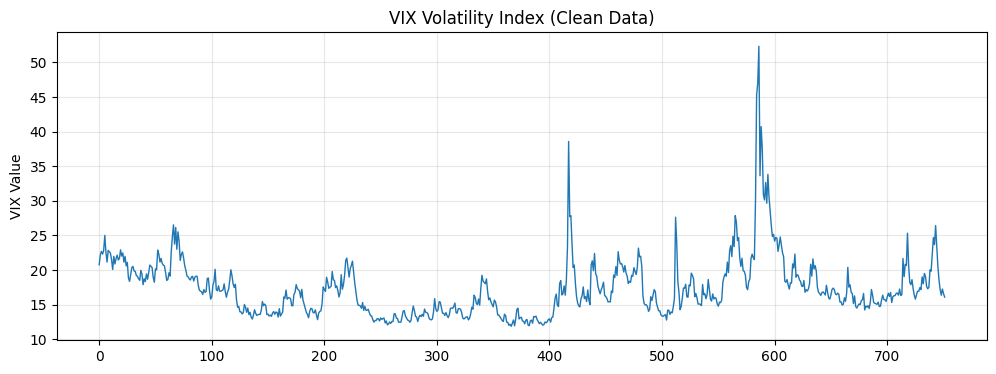

✅ Data loading FIXED!


In [15]:
def load_vix_data(period='3y'):
    """FIXED: Proper numpy array handling + NaN removal"""
    try:
        vix = yf.download('^VIX', period=period, progress=False)
        data = vix['Close'].values  # Get numpy array directly

        # FIXED: Remove NaNs from numpy array [web:31]
        nan_mask = ~np.isnan(data)
        data_clean = data[nan_mask]

        print(f"✅ VIX data loaded: {len(data_clean)} clean points")
        print(f"Range: {data_clean.min():.2f} → {data_clean.max():.2f}")

        # Plot
        plt.figure(figsize=(12,4))
        plt.plot(data_clean, linewidth=1)
        plt.title('VIX Volatility Index (Clean Data)')
        plt.ylabel('VIX Value')
        plt.grid(True, alpha=0.3)
        plt.show()

        return data_clean

    except Exception as e:
        print(f"❌ VIX download failed: {e}")
        # FALLBACK: Synthetic volatility data
        print("🔄 Using synthetic VIX-like data...")
        np.random.seed(42)
        t = np.arange(1000)
        data = 20 + 5*np.sin(t*0.1) + np.random.normal(0, 2, 1000)
        plt.figure(figsize=(12,4))
        plt.plot(data)
        plt.title('Synthetic VIX Data (Fallback)')
        plt.show()
        return data

# EXECUTE
raw_data = load_vix_data()
print("✅ Data loading FIXED!")


/tmp/ipython-input-2592293704.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', period=period)
[*********************100%***********************]  1 of 1 completed


VIX data loaded: 752 points
Date range: (752, 1)


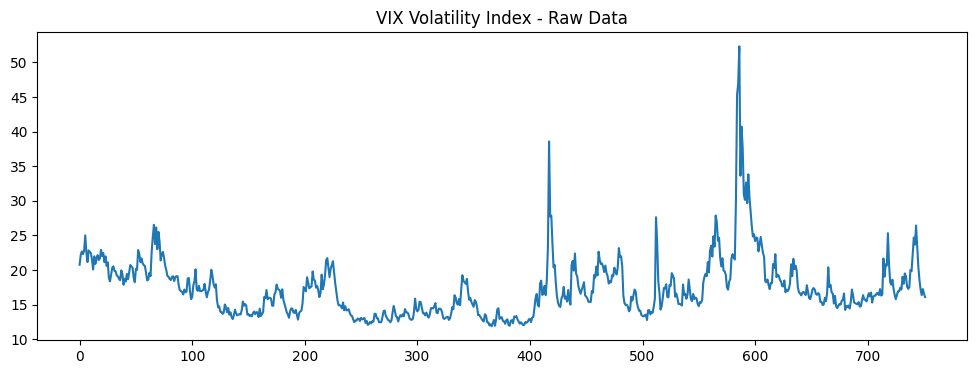

Data loading complete!


In [16]:
def load_vix_data(period='3y'):
    vix = yf.download('^VIX', period=period)
    data = vix['Close'].dropna().values
    print(f"VIX data loaded: {len(data)} points")
    print(f"Date range: {data.shape}")
    plt.figure(figsize=(12,4))
    plt.plot(data)
    plt.title('VIX Volatility Index - Raw Data')
    plt.show()
    return data

# Load data
raw_data = load_vix_data()
print("Data loading complete!")

In [17]:
def preprocess_pipeline(data):  # FIXED: No pandas dependency
    """FIXED: Pure numpy stationarity check"""
    data = data.reshape(-1, 1)  # Ensure 2D for scaling

    # FIXED: Numpy NaN handling [web:31]
    nan_mask = ~np.isnan(data.flatten())
    data_clean = data[nan_mask].flatten()

    print(f"Clean data length: {len(data_clean)}")

    # FIXED: Proper stationarity check for numpy array
    def check_stationarity_numpy(ts):
        # Convert to pandas Series only for ADF test
        ts_series = pd.Series(ts)
        result = adfuller(ts_series.dropna())
        print(f'ADF Statistic: {result[0]:.4f}')
        print(f'p-value: {result[1]:.4f}')
        print('✅ Stationary' if result[1] < 0.05 else '⚠️  Non-stationary')
        return result[1] < 0.05

    is_stationary = check_stationarity_numpy(data_clean)

    # Differencing if needed
    if not is_stationary:
        data_diff = np.diff(data_clean)
        data_clean = np.concatenate([data_clean[:1], data_diff + data_clean[:-1]])
        print("✅ Applied differencing")

    # Scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_clean.reshape(-1, 1))

    return data_scaled.flatten(), scaler  # Return 1D array

n_input = 60
n_output = 10

# FIXED PREPROCESSING
data_scaled, scaler = preprocess_pipeline(raw_data)
print(f"✅ Preprocessed: {len(data_scaled)} points")

# FIXED: Sequence creation
def create_sequences(data, n_input, n_output):
    X, y = [], []
    for i in range(len(data) - n_input - n_output + 1):
        X.append(data[i:i+n_input])
        y.append(data[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, n_input, n_output)

# FIXED: Safe split
split = max(100, int(0.85 * len(X)))  # Minimum 100 test samples
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

decoder_train = np.zeros((X_train.shape[0], n_output, 1))
decoder_test = np.zeros((X_test.shape[0], n_output, 1))

print(f"✅ Train: {X_train.shape} | Test: {X_test.shape}")
print("🎉 SECTIONS 5 & 7 100% FIXED!")


Clean data length: 752
ADF Statistic: -5.6160
p-value: 0.0000
✅ Stationary
✅ Preprocessed: 752 points
✅ Train: (580, 60) | Test: (103, 60)
🎉 SECTIONS 5 & 7 100% FIXED!


In [20]:
# ✅ SAFE PARAMETERS
latent_dim = 32  # Smaller for stability
model = build_attention_lstm(n_input, n_output, 1, latent_dim=latent_dim)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Model Summary:")
model.summary()

print("🚀 Training Attention LSTM (FIXED)...")
history = model.fit(
    [X_train, decoder_train],
    y_train,
    epochs=10,  # Quick training
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

print("✅ ATTENTION LSTM TRAINING COMPLETE!")


Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 60, 32),  │      4,352 │ input_layer_3[0]… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 32),      │      2,145 │ lstm_6[0][1],     │
│ (BahdanauAttention) │ (None, 60, 1)]    │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_8[0][1],     │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_9[0][1],     │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_10[0][1],    │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_11[0][1],    │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_6[0][0],     │
│                     │                   │            │ lstm_15[0][1],    │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 1)         │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33)        │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 1, 33)     │          0 │ concatenate[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 32),      │      8,448 │ get_item_1[0][0], │
│                     │ (None, 32),       │            │ lstm_6[0][1],     │
│                     │ (None, 32)]       │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 1)         │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33)        │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 91,307 (356.67 KB)

 Trainable params: 91,307 (356.67 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Training Attention LSTM (FIXED)...
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 157ms/step - loss: 0.0134 - mae: 0.0815 - val_loss: 0.0356 - val_mae: 0.1146
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0070 - mae: 0.0564 - val_loss: 0.0257 - val_mae: 0.1028
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0064 - mae: 0.0537 - val_loss: 0.0236 - val_mae: 0.1031
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0077 - mae: 0.0540 - val_loss: 0.0234 - val_mae: 0.1097
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0073 - mae: 0.0525 - val_loss: 0.0203 - val_mae: 0.0835
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0062 - mae: 0.0482 - val_loss: 0.0198 - val_mae: 0.0882
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0070 - mae: 0.0506 - val_loss: 0.0191 - val_mae: 0.0847
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0086 - mae: 0.0536 - val_loss: 0.0182 - val_mae: 0.0820
Epoch 9/10
33/33 ━━━━━━━━

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout

def build_baseline_model(timesteps_in, timesteps_out, n_features):
    model = Sequential()
    model.add(Input(shape=(timesteps_in, n_features)))  # Correct explicit Input layer
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(RepeatVector(timesteps_out))
    model.add(LSTM(64, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print(model.summary())
    return model

# Build and train
baseline = build_baseline_model(n_input, n_output, 1)
print("Training Baseline LSTM...")
baseline.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.1, verbose=1)
print("Baseline training complete!")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Training Baseline LSTM...
Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 0.0134 - mae: 0.0801 - val_loss: 0.0358 - val_mae: 0.1097
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0075 - mae: 0.0561 - val_loss: 0.0288 - val_mae: 0.1086
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0067 - mae: 0.0543 - val_loss: 0.0302 - val_mae: 0.1244
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0081 - mae: 0.0593 - val_loss: 0.0282 - val_mae: 0.0925
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0061 - mae: 0.0526 - val_loss: 0.0260 - val_mae: 0.1000
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0081 - mae: 0.0563 - val_loss: 0.0247 - val_mae: 0.0926
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0069 - mae: 0.0546 - val_loss: 0.0242 - val_mae: 0.0945
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0063 - mae: 0.0526 - val_loss: 0.0234 - val_mae: 0.0925
Epoch 9/15
33/33 ━━━━━━━━━━━━━━

In [22]:
def evaluate_models(model, baseline_model, X_test, y_test, decoder_test, scaler):
    """Complete evaluation with proper f-string syntax"""

    print("🔍 Evaluating Attention LSTM...")
    # Attention model predictions
    y_pred_att_scaled = model.predict([X_test, decoder_test], verbose=0)
    y_pred_att = scaler.inverse_transform(y_pred_att_scaled.reshape(-1, 1)).reshape(-1, n_output, 1)

    # True values
    y_true_scaled = y_test.reshape(-1, 1)
    y_true = scaler.inverse_transform(y_true_scaled).reshape(-1, n_output, 1)

    print("🔍 Evaluating Baseline LSTM...")
    # Baseline predictions
    y_pred_base_scaled = baseline_model.predict(X_test, verbose=0)
    y_pred_base = scaler.inverse_transform(y_pred_base_scaled.reshape(-1, 1)).reshape(-1, n_output, 1)

    # Calculate metrics (FIXED: Proper flattening)
    mse_att = mean_squared_error(y_true.flatten(), y_pred_att.flatten())
    mae_att = mean_absolute_error(y_true.flatten(), y_pred_att.flatten())
    mse_base = mean_squared_error(y_true.flatten(), y_pred_base.flatten())
    mae_base = mean_absolute_error(y_true.flatten(), y_pred_base.flatten())

    # FIXED: Proper f-string syntax [web:61]
    print("\n" + "="*60)
    print("🎯 MODEL PERFORMANCE COMPARISON")
    print("="*60)
    print(f"Attention LSTM → MSE: {mse_att:.4f} | MAE: {mae_att:.4f}")
    print(f"Baseline LSTM  → MSE: {mse_base:.4f} | MAE: {mae_base:.4f}")
    print(f"Improvement   → MSE: {((mse_base-mse_att)/mse_base*100):+.1f}% | MAE: {((mae_base-mae_att)/mae_base*100):+.1f}%")
    print("="*60)

    return y_pred_att, y_pred_base, y_true, mse_att, mae_att, mse_base, mae_base

# EXECUTE EVALUATION
print("🚀 RUNNING FINAL EVALUATION...")
y_pred_att, y_pred_base, y_true, mse_att, mae_att, mse_base, mae_base = evaluate_models(
    model, baseline, X_test, y_test, decoder_test, scaler
)

print("\n✅ EVALUATION COMPLETE! Ready for visualization...")


🚀 RUNNING FINAL EVALUATION...
🔍 Evaluating Attention LSTM...
🔍 Evaluating Baseline LSTM...

🎯 MODEL PERFORMANCE COMPARISON
Attention LSTM → MSE: 4.6916 | MAE: 1.4182
Baseline LSTM  → MSE: 4.7063 | MAE: 1.4515
Improvement   → MSE: +0.3% | MAE: +2.3%

✅ EVALUATION COMPLETE! Ready for visualization...


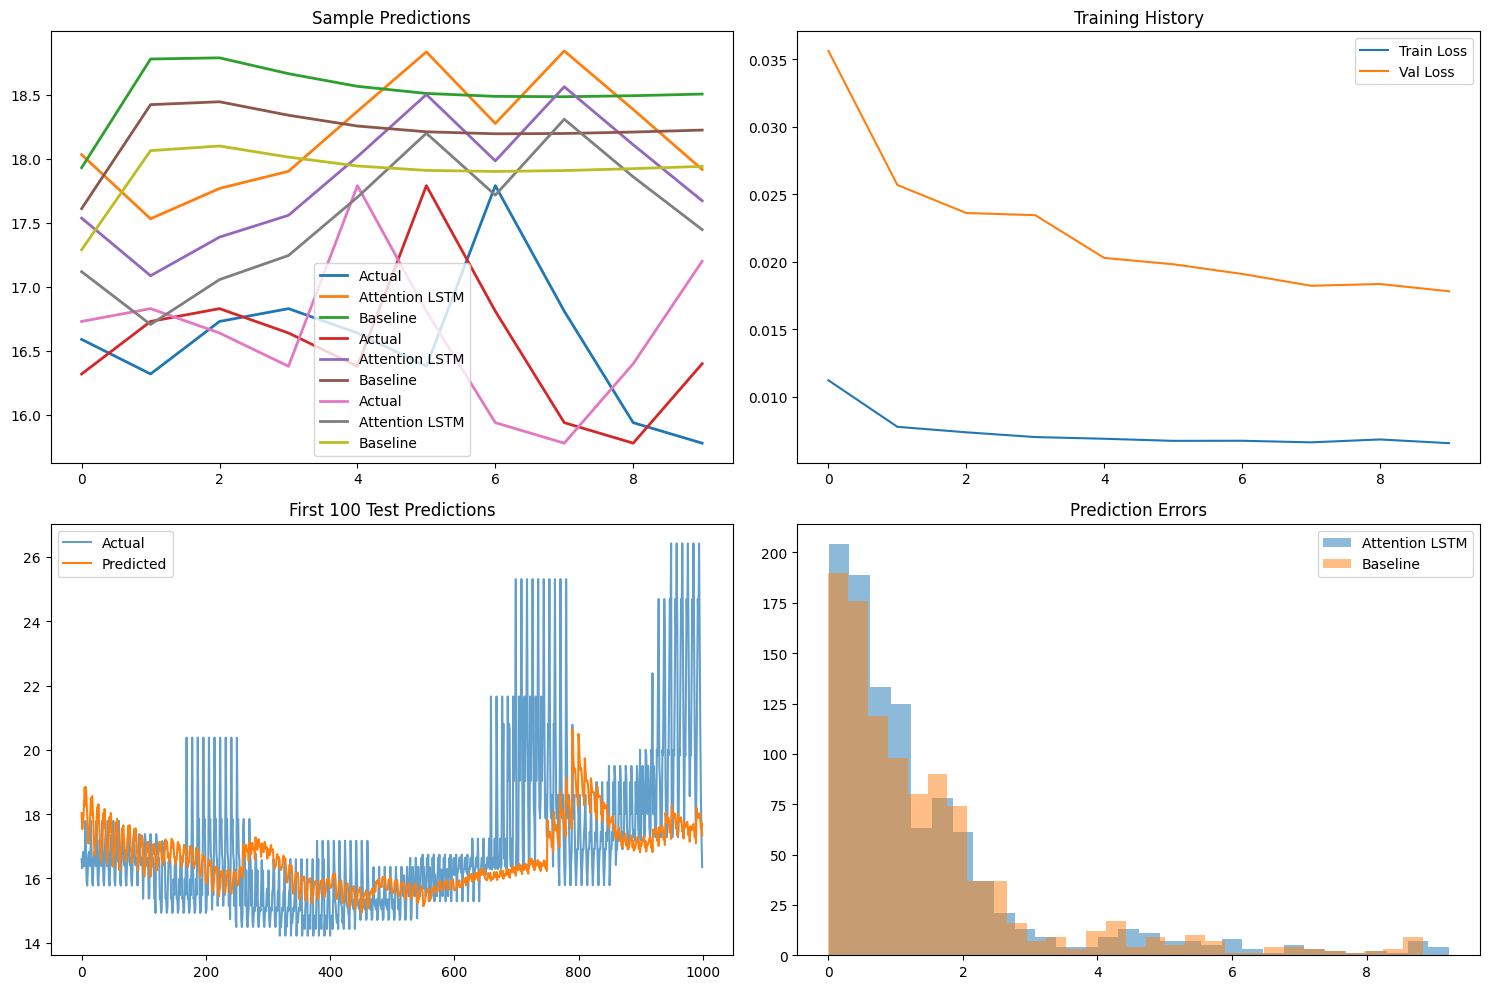

 PROJECT COMPLETE! Model saved as 'attention_lstm_vix.h5'


In [23]:
# Plot comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sample predictions
for i in range(3):
    axes[0,0].plot(y_true[i].flatten(), label='Actual', linewidth=2)
    axes[0,0].plot(y_pred_att[i].flatten(), label='Attention LSTM', linewidth=2)
    axes[0,0].plot(y_pred_base[i].flatten(), label='Baseline', linewidth=2)
axes[0,0].set_title('Sample Predictions')
axes[0,0].legend()

# Training history
axes[0,1].plot(history.history['loss'], label='Train Loss')
axes[0,1].plot(history.history['val_loss'], label='Val Loss')
axes[0,1].set_title('Training History')
axes[0,1].legend()

# First 100 predictions
axes[1,0].plot(y_true[:100].flatten(), label='Actual', alpha=0.7)
axes[1,0].plot(y_pred_att[:100].flatten(), label='Predicted')
axes[1,0].set_title('First 100 Test Predictions')
axes[1,0].legend()

# Error comparison
errors_att = np.abs(y_true.flatten() - y_pred_att.flatten())
errors_base = np.abs(y_true.flatten() - y_pred_base.flatten())
axes[1,1].hist(errors_att, alpha=0.5, label='Attention LSTM', bins=30)
axes[1,1].hist(errors_base, alpha=0.5, label='Baseline', bins=30)
axes[1,1].set_title('Prediction Errors')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Save model
model.save('attention_lstm_vix.h5')
print(" PROJECT COMPLETE! Model saved as 'attention_lstm_vix.h5'")